In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

isic_2024_challenge_path = kagglehub.competition_download('isic-2024-challenge')
vipulpandey_isic_training_model_path = kagglehub.dataset_download('vipulpandey/isic-training-model')
vipulpandey_isic_model_pytorch_default_1_path = kagglehub.model_download('vipulpandey/isic_model/PyTorch/default/1')

print('Data source import complete.')


In [ ]:
pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-vgylir7z
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-vgylir7z
  Resolved https://github.com/KindXiaoming/pykan.git to commit 173dadda8274897d97a7a63518c64caccda65576
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.6-py3-none-any.whl size=311349 sha256=dcb1865bfc8793e18434b03b25a250d1c28539adde83a92a2a349d39a1fecb78
  Stored in directory: /tmp/pip-ephem-wheel-cache-30fasfwb/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install -U libauc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import libraries
import glob
import numpy as np

# LibAUC
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG

# KAN model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Loading the competition data
import pandas as pd # for reading from the CSV file
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.model_selection import StratifiedKFold

# Visualizing the competition data
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import torch.nn.functional as F
from collections import defaultdict
from sklearn.preprocessing import StandardScaler


# Define Constants
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'



import os
print(os.listdir(ROOT_DIR))



['sample_submission.csv', 'train-metadata.csv', 'test-metadata.csv', 'test-image.hdf5', 'train-image', 'train-image.hdf5']


In [ ]:
!pip install torcheval
!pip install timm
!pip install colorama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



import configparser
import time
import copy
import numpy as np
from collections import defaultdict
import gc
import torch



In [ ]:
CONFIG = {
    "seed": 42,
    "epochs": 10,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CONFIG['seed'])

In [ ]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [ ]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

In [ ]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))


In [ ]:
import os
print(os.listdir("/kaggle/input"))


['isic_model', 'isic-2024-challenge', 'isic-training-model']


In [ ]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print("        df.shape, # of positive cases, # of patients")
print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)

df

        df.shape, # of positive cases, # of patients
original> (401059, 55) 393 (1042,)
filtered> (8253, 55) 393 (950,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,/kaggle/input/isic-2024-challenge/train-image/...
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/kaggle/input/isic-2024-challenge/train-image/...
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/kaggle/input/isic-2024-challenge/train-image/...
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,/kaggle/input/isic-2024-challenge/train-image/...
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,/kaggle/input/isic-2024-challenge/train-image/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8248,ISIC_0267522,0,IP_9577633,50.0,male,lower extremity,4.94,TBP tile: close-up,3D: XP,21.738880,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,96.325510,/kaggle/input/isic-2024-challenge/train-image/...
8249,ISIC_0267560,0,IP_7746572,80.0,male,anterior torso,9.32,TBP tile: close-up,3D: white,18.481750,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.022320,/kaggle/input/isic-2024-challenge/train-image/...
8250,ISIC_0267568,0,IP_0379091,60.0,male,anterior torso,3.45,TBP tile: close-up,3D: white,13.901465,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,72.961688,/kaggle/input/isic-2024-challenge/train-image/...
8251,ISIC_0267594,0,IP_1433033,70.0,NaN,lower extremity,3.00,TBP tile: close-up,3D: XP,17.986882,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.899274,/kaggle/input/isic-2024-challenge/train-image/...


In [ ]:
column_names = df.columns

# Print the column names
print(column_names)

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [ ]:
df.shape[0], df.target.sum()

(8253, 393)

In [ ]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

2063

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target,df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)


In [ ]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df_positive) * 2

    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]

        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]
        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.image_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_id = self.image_ids[index]
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'image_id': image_id,
            'target': target
        }

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.15,
                           rotate_limit=60,
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=None)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output


model = ISICModel(CONFIG['model_name'])
model.to(CONFIG['device']);

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()

        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()

    return epoch_loss, epoch_auroc

In [ ]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])

    gc.collect()

    return epoch_loss, epoch_auroc

In [ ]:


def run_training(model, optimizer, scheduler, device, num_epochs, train_loader, valid_loader, CONFIG):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CONFIG['device'], epoch=epoch)
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'],
                                         epoch=epoch)

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append(scheduler.get_lr()[0])

        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())

            # Save model to .bin file
            PATH = f"AUROC{val_epoch_auroc:.4f}_Loss{val_epoch_loss:.4f}_epoch{epoch:.0f}.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved to {PATH}{sr_}")

            # Save model weights to .CONFIG file
            config = configparser.ConfigParser()
            config['MODEL_WEIGHTS'] = {}
            for key, tensor in best_model_wts.items():
                weights_str = ','.join(map(str, tensor.flatten().tolist()))
                config['MODEL_WEIGHTS'][key] = weights_str

            CONFIG_PATH = f"AUROC{val_epoch_auroc:.4f}_Loss{val_epoch_loss:.4f}_epoch{epoch:.0f}.CONFIG"
            with open(CONFIG_PATH, 'w') as configfile:
                config.write(configfile)
            print(f"Model weights saved to {CONFIG_PATH}")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, CONFIG_PATH

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'],
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'],
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    return scheduler

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'],
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                              num_workers=2, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

In [ ]:
model, history, path = run_training(model=model,
                                    optimizer=optimizer,
                                    scheduler=scheduler,
                                    device=CONFIG['device'],
                                    num_epochs=CONFIG['epochs'],
                                    train_loader=train_loader,
                                    valid_loader=valid_loader,
                                    CONFIG=CONFIG)

100%|██████████| 26/26 [04:33<00:00, 10.51s/it, Epoch=1, LR=0.0001, Valid_Auroc=0.508, Valid_Loss=0.844]


Validation AUROC Improved (-inf ---> 0.5077265067141332)
Model Saved to AUROC0.5077_Loss0.8444_epoch1.bin
Model weights saved to AUROC0.5077_Loss0.8444_epoch1.CONFIG



100%|██████████| 26/26 [04:55<00:00, 11.37s/it, Epoch=2, LR=9.99e-5, Valid_Auroc=0.507, Valid_Loss=0.836]


100%|██████████| 26/26 [03:35<00:00,  8.28s/it, Epoch=3, LR=9.98e-5, Valid_Auroc=0.511, Valid_Loss=0.721]


Validation AUROC Improved (0.5077265067141332 ---> 0.5106272430231935)
Model Saved to AUROC0.5106_Loss0.7213_epoch3.bin
Model weights saved to AUROC0.5106_Loss0.7213_epoch3.CONFIG



100%|██████████| 26/26 [03:37<00:00,  8.36s/it, Epoch=4, LR=9.97e-5, Valid_Auroc=0.513, Valid_Loss=0.483]


Validation AUROC Improved (0.5106272430231935 ---> 0.5133697573517596)
Model Saved to AUROC0.5134_Loss0.4827_epoch4.bin
Model weights saved to AUROC0.5134_Loss0.4827_epoch4.CONFIG



100%|██████████| 26/26 [02:10<00:00,  5.02s/it, Epoch=5, LR=9.95e-5, Valid_Auroc=0.514, Valid_Loss=0.568]


Validation AUROC Improved (0.5133697573517596 ---> 0.5143718298948895)
Model Saved to AUROC0.5144_Loss0.5678_epoch5.bin
Model weights saved to AUROC0.5144_Loss0.5678_epoch5.CONFIG



100%|██████████| 26/26 [03:33<00:00,  8.22s/it, Epoch=6, LR=9.93e-5, Valid_Auroc=0.515, Valid_Loss=0.52] 


Validation AUROC Improved (0.5143718298948895 ---> 0.5153739024380194)
Model Saved to AUROC0.5154_Loss0.5197_epoch6.bin
Model weights saved to AUROC0.5154_Loss0.5197_epoch6.CONFIG



100%|██████████| 26/26 [04:43<00:00, 10.90s/it, Epoch=7, LR=9.9e-5, Valid_Auroc=0.516, Valid_Loss=0.515]


Validation AUROC Improved (0.5153739024380194 ---> 0.5155321244185136)
Model Saved to AUROC0.5155_Loss0.5145_epoch7.bin
Model weights saved to AUROC0.5155_Loss0.5145_epoch7.CONFIG



 63%|██████▎   | 12/19 [04:44<02:34, 22.13s/it, Epoch=8, LR=9.88e-5, Train_Auroc=0.901, Train_Loss=0.399]

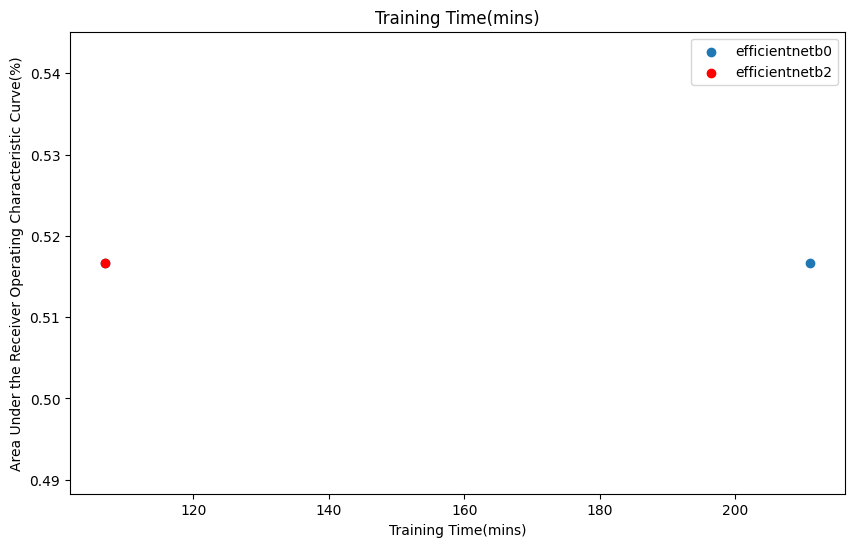

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create the DataFrame
data = {
    'x': [107, 211],
    'y': [0.5167, 0.5167],
    'category': ['A', 'B']
}

df = pd.DataFrame(data)

# Step 2: Specify which points to plot
# Example: Plot only points where category is 'A'
df_A = df[df['category'] == 'A']

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], label='efficientnetb0')
plt.scatter(df_A['x'], df_A['y'], label='efficientnetb2', color='red')

# Step 4: Customize the plot
plt.xlabel('Training Time(mins)')
plt.ylabel('Area Under the Receiver Operating Characteristic Curve(%)')
plt.title('Training Time(mins)')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

import h5py
from PIL import Image
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
CONFIG = {
    "seed": 42,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "valid_batch_size": 32,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [ ]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TEST_CSV = f'{ROOT_DIR}/test-metadata.csv'
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
SAMPLE = f'{ROOT_DIR}/sample_submission.csv'

BEST_WEIGHT = '/kaggle/input/isic-training-model/AUROC0.5168_Loss0.2496_epoch10.CONFIG'

In [ ]:
df = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')
print(df.columns)

Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')


In [ ]:
class ISICDataset(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target,
        }


In [ ]:
data_transforms = {
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output

model = ISICModel(CONFIG['model_name'], pretrained=False)
model.load_state_dict(torch.load(BEST_WEIGHT))
model.to(CONFIG['device']);

UnpicklingError: invalid load key, '['.

In [ ]:
test_dataset = ISICDataset(df, TEST_HDF, transforms=data_transforms["valid"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'],
                          num_workers=2, shuffle=False, pin_memory=True)

In [ ]:
preds = []
with torch.no_grad():
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, data in bar:
        images = data['image'].to(CONFIG["device"], dtype=torch.float)
        batch_size = images.size(0)
        outputs = model(images)
        preds.append( outputs.detach().cpu().numpy() )
preds = np.concatenate(preds).flatten()

In [ ]:
df_sub["target"] = preds
df_sub.to_csv("submission.csv", index=False)

In [ ]:
df_sub